In [104]:
!pip install -U transformers --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import nltk

In [106]:
import torch

In [107]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [108]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Exploratory Data-Analysis

In [109]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [110]:
df.shape,df.columns

((568454, 10),
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
        'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
       dtype='object'))

In [111]:
df['HelpfulnessDenominator'].value_counts()

HelpfulnessDenominator
0      270052
1      112753
2       61482
3       34394
4       22306
        ...  
230         1
145         1
282         1
113         1
815         1
Name: count, Length: 234, dtype: int64

In [112]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [113]:
df_numeric = df[[col for col in ['HelpfulnessNumerator','HelpfulnessDenominator','Score','Time']]]
df_numeric.columns

Index(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time'], dtype='object')

<Axes: >

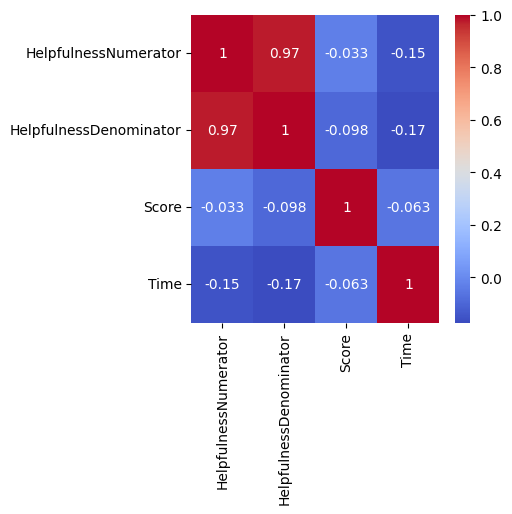

In [114]:
plt.figure(figsize=(4,4))
sns.heatmap(df_numeric.corr(),annot=True,cmap='coolwarm')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='HelpfulnessNumerator', ylabel='Density'>

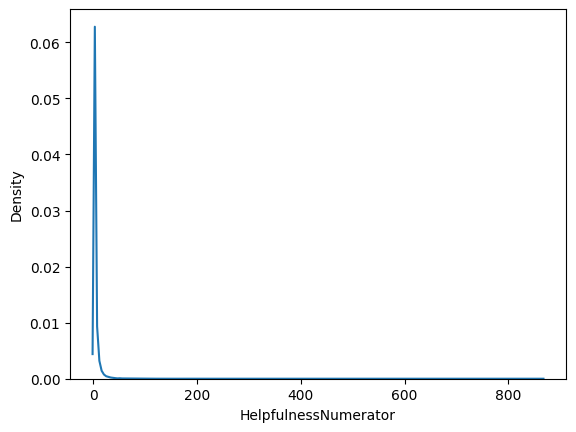

In [115]:
sns.kdeplot(data=df_numeric, x="HelpfulnessNumerator")

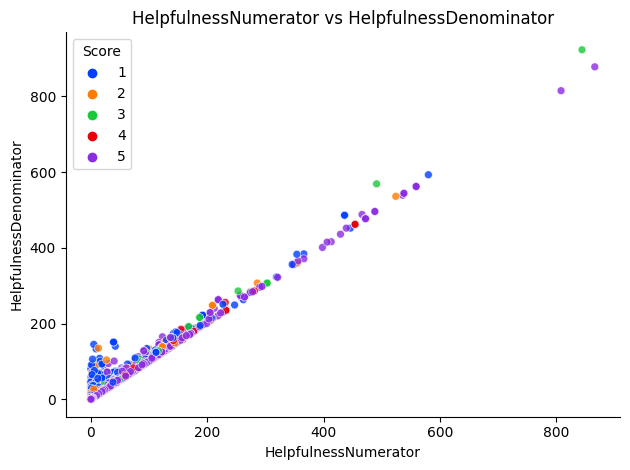

In [116]:
sns.scatterplot(data=df,x='HelpfulnessNumerator',y='HelpfulnessDenominator',hue='Score',
              palette='bright',s=32,alpha=0.8)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('HelpfulnessNumerator')
plt.ylabel('HelpfulnessDenominator')
plt.title('HelpfulnessNumerator vs HelpfulnessDenominator')
plt.tight_layout()
plt.show()

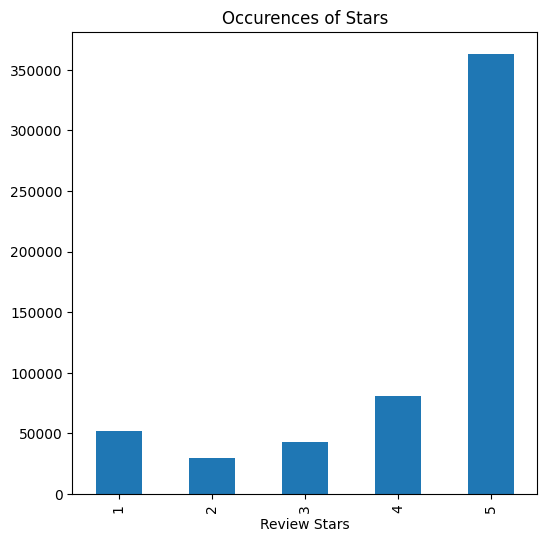

In [117]:
ax = df['Score'].value_counts().sort_index().plot(
    kind = 'bar' , title = 'Occurences of Stars',
    figsize = (6,6)
)
ax.set_xlabel('Review Stars')
plt.show()

In [118]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## NLTK(Natural Language Tool-Kit)

In [119]:
sample = df['Text'][50]
tokens = nltk.word_tokenize(sample)
print(tokens)

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft', ',', 'I', 'do', "n't", 'like', 'it', '.', 'Quaker', 'Oats', 'is', 'the', 'way', 'to', 'go', '.']


In [120]:
tagged = nltk.pos_tag(tokens)
tagged

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ'),
 (',', ','),
 ('I', 'PRP'),
 ('do', 'VBP'),
 ("n't", 'RB'),
 ('like', 'VB'),
 ('it', 'PRP'),
 ('.', '.'),
 ('Quaker', 'NNP'),
 ('Oats', 'NNPS'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('.', '.')]

In [121]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [122]:
sample

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [123]:
sia.polarity_scores(sample)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [124]:
df_new = df.head(500)

In [125]:
scores ={}
for i, row in tqdm(df_new.iterrows() , total = len(df_new)):
    text = row['Text']
    ID = row['Id']
    scores[ID] = sia.polarity_scores(text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [126]:
df_new.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## VADER

In [127]:
vaders = pd.DataFrame(scores).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df_new,how='left')

In [128]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


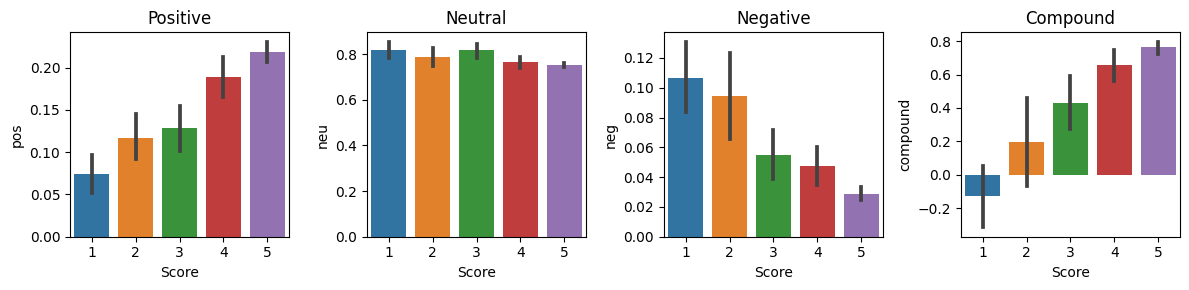

In [129]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
sns.barplot(data=vaders, x='Score', y='compound', ax=axs[3])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
axs[3].set_title('Compound')
plt.tight_layout()
plt.show()

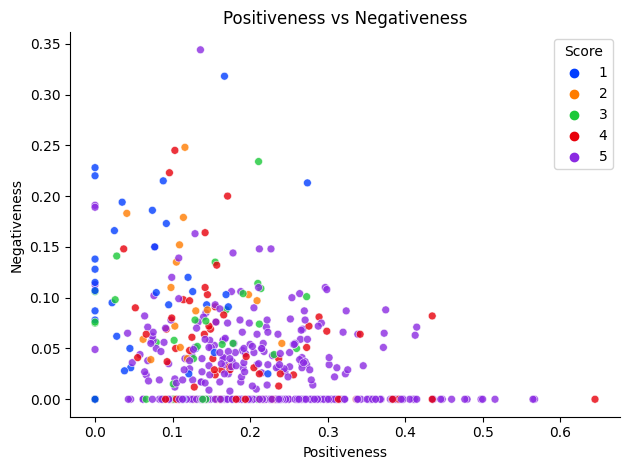

In [130]:
sns.scatterplot(data=vaders,x='pos',y='neg',hue='Score',
              palette='bright',s=32,alpha=0.8)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Positiveness')
plt.ylabel('Negativeness')
plt.title('Positiveness vs Negativeness')
plt.tight_layout()
plt.show()

In [131]:
vaders.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

<Axes: >

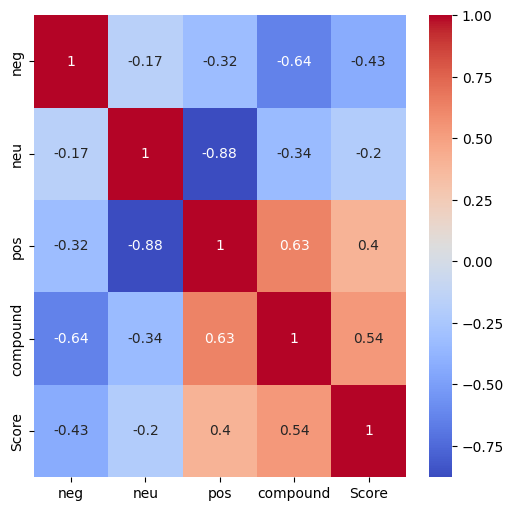

In [132]:
vaders_use = vaders[[col for col in ['neg', 'neu', 'pos', 'compound','Score']]]
plt.figure(figsize=(6,6))
sns.heatmap(vaders_use.corr() , annot = True , cmap='coolwarm')

## RoBERTa(Robustly Optimized BERT Approach)

In [146]:
from transformers import AutoTokenizer
from scipy.special import softmax
from transformers import AutoModelForSequenceClassification

In [147]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [148]:
sample

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [150]:
text = sample
encoded_input = tokenizer(text, return_tensors='pt')
# Since this is only for inference
with torch.no_grad():
      output = model(**encoded_input)
# output : SequenceClassifierOutput(loss=None, logits=tensor([[ 3.1436, -0.7107, -2.6559]]), hidden_states=None, attentions=None)
scores = output[0][0].detach().numpy()
# scores : array([ 3.1436298, -0.7106689, -2.655897 ], dtype=float32)
scores = softmax(scores)
# scores : array([0.97635514, 0.02068746, 0.00295737], dtype=float32)
scores

array([0.97635514, 0.02068746, 0.00295737], dtype=float32)

In [156]:
def polarity_scores_Roberta(text):
    encoded_input = tokenizer(text, return_tensors='pt',truncation = True,max_length = 512)
    with torch.no_grad():
         output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    dict_Roberta = {
        'Roberta_neg': scores[0],
        'Roberta_neu': scores[1],
        'Roberta_pos': scores[2]
    }
    return dict_Roberta

In [154]:
df_new.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [158]:
polarity_scores_Roberta(sample)

{'Roberta_neg': 0.97635514,
 'Roberta_neu': 0.020687463,
 'Roberta_pos': 0.002957368}

In [159]:
Roberta ={}
for i, row in tqdm(df_new.iterrows() , total = len(df_new)):
    text = row['Text']
    ID = row['Id']
    Roberta[ID] = polarity_scores_Roberta(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [166]:
df_roberta = pd.DataFrame(Roberta).T
# df_roberta = df_roberta.reset_index().rename(columns={'index':'Id'})
# df_roberta = df_roberta.merge(df_new , how='left')

In [167]:
df_roberta.head()

,Roberta_neg,Roberta_neu,Roberta_pos
1,0.009624,0.049980,0.940395
2,0.508986,0.452414,0.038600
3,0.003229,0.098067,0.898704
4,0.002295,0.090219,0.907486
5,0.001635,0.010302,0.988063


In [211]:
vaders  = vaders.rename(columns={'neg':'Vader_negative', 'neu':'Vader_neutral',
                                 'pos':'Vader_positive','compound':'Vader_compound'})

In [212]:
vaders.columns

Index(['Id', 'Vader_negative', 'Vader_neutral', 'Vader_positive',
       'Vader_compound', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

In [213]:
df_roberta.columns

Index(['Roberta_neg', 'Roberta_neu', 'Roberta_pos'], dtype='object')

In [214]:
results_df = pd.concat([df_roberta,vaders],axis = 1)

In [215]:
results_df = results_df.reset_index().rename(columns={'index':'Id'})

In [216]:
results_df.head()

,Id,Roberta_neg,Roberta_neu,Roberta_pos,Id,Vader_negative,Vader_neutral,Vader_positive,Vader_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,2.0,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,2,0.508986,0.452414,0.038600,3.0,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
2,3,0.003229,0.098067,0.898704,4.0,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
3,4,0.002295,0.090219,0.907486,5.0,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...
4,5,0.001635,0.010302,0.988063,6.0,0.029,0.809,0.163,0.8830,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0.0,0.0,4.0,1.342051e+09,Nice Taffy,I got a wild hair for taffy and ordered this f...


In [217]:
results_df.columns

Index(['Id', 'Roberta_neg', 'Roberta_neu', 'Roberta_pos', 'Id',
       'Vader_negative', 'Vader_neutral', 'Vader_positive', 'Vader_compound',
       'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

<Axes: >

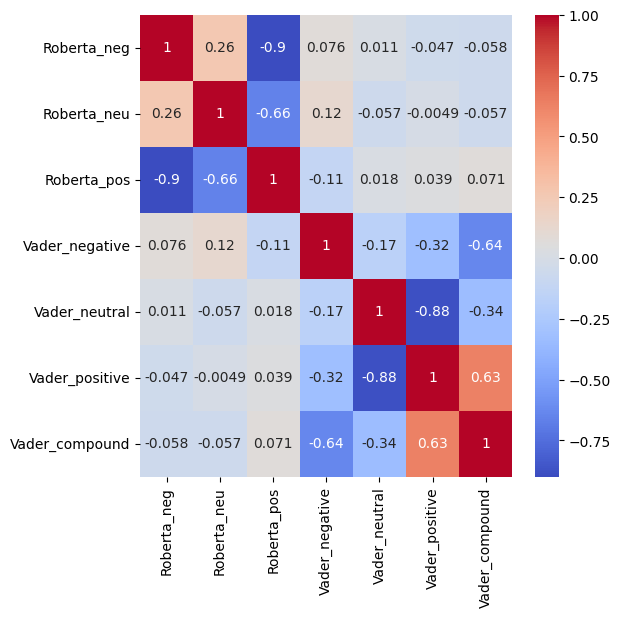

In [219]:
results_df_use = results_df[[col for col in ['Roberta_neg', 'Roberta_neu', 'Roberta_pos',
       'Vader_negative', 'Vader_neutral', 'Vader_positive', 'Vader_compound']]]
plt.figure(figsize=(6,6))
sns.heatmap(results_df_use.corr() , annot = True , cmap='coolwarm')

## With a Pipeline

In [224]:
from transformers import pipeline
pipe = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [225]:
pipe ("This is so good!!")

[{'label': 'POSITIVE', 'score': 0.999849796295166}]

* How a `barely` can turn the sentiment of sentence upside down  !!

In [228]:
print(pipe("This is good enough to catch the crowd"))
print(pipe("This is barely good enough to catch the crowd"))

[{'label': 'POSITIVE', 'score': 0.9998512268066406}]
[{'label': 'NEGATIVE', 'score': 0.999518871307373}]
